In [1]:
#pip install umap-learn

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.recommendation import ALS
from pyspark.sql import SparkSession
from sklearn.manifold import TSNE
import umap.umap_ as UMAP
import json
from sklearn.decomposition import PCA
import random

In [3]:
def load_features(filename):
    id_list = []
    features = []
    with open(filename) as f:
        lines = f.readlines()
        for line in lines:
            line =  line[7:-3] # get rid of "Row(id=" in the beginning and "])\n" in the end
            line =  line.split(', features=[')
            idd = int(line[0]) # first element is the id
            id_list.append(idd)
            feat = [float(x) for x in line[1].split(', ')] # second element are the features
            features.append(feat)
    return id_list, np.array(features)

item_ids, item_features  = load_features('results/item_factor_old')
user_ids, user_features  = load_features('results/user_factor_old')

In [4]:
popularity_df = pd.read_csv("results/items_popularity.csv")
popularity_dict = dict(zip(popularity_df['movieId'], popularity_df['popularity']))
popularity_list = [popularity_dict[x] for x in item_ids]

In [5]:
genres_df = pd.read_csv("results/movies.csv")
genres_dict = dict(zip(genres_df['movieId'], genres_df['genres']))
genres_list = [genres_dict[x].split('|') for x in item_ids]
genre_list = [random.choice(l) for l in genres_list]
print(len(set(genre_list)), set(genre_list))

20 {'Horror', 'Children', 'Fantasy', 'Romance', 'IMAX', 'Western', 'Adventure', 'Crime', 'Musical', 'Film-Noir', 'Sci-Fi', 'Action', 'Documentary', 'Thriller', 'War', 'Mystery', 'Comedy', 'Animation', 'Drama', '(no genres listed)'}


/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


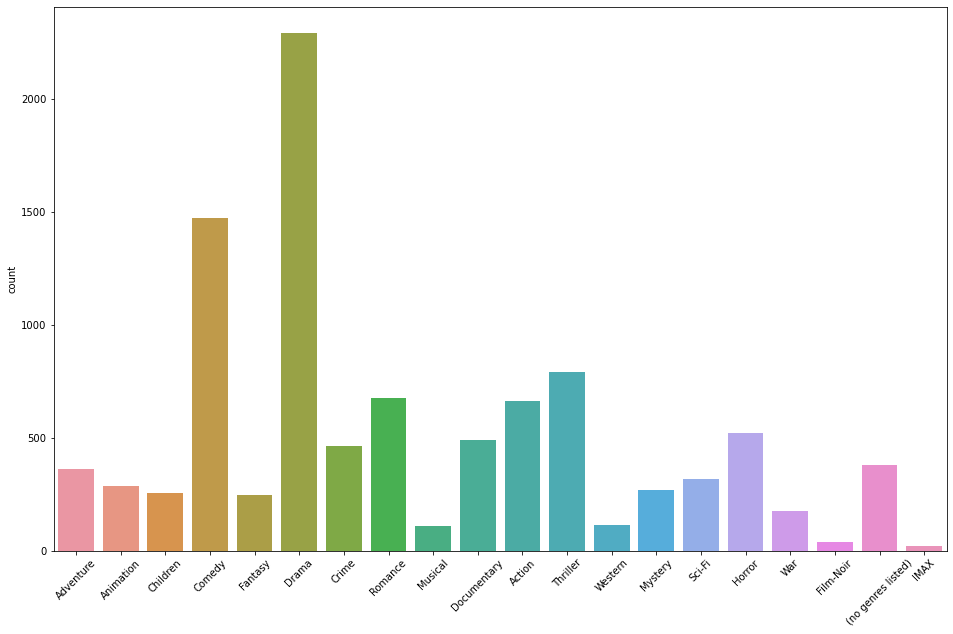

In [6]:
genre_list_all = sum(genres_list, [])
plt.figure(figsize=(16,10))
sns.countplot(genre_list_all)
plt.xticks(rotation=45)
plt.savefig('results/genre')

In [7]:
#overall_genre = ['Comedy', 'Drama', 'Romance', 'Documentary', 'Action', 'Thriller', '(no genres listed)']
#def get_overall_genre(l):
#    results = list(set(overall_genre).intersection(set(l)))
#    if results:
#        return random.choice(results)
#    else: 
#        return '(no genres listed)'
#genre_list = [get_overall_genre(l) for l in genres_list]
#print(len(set(genre_list)), set(genre_list))

In [8]:
#import collections
#genre_hue_order=[x[0] for x in collections.Counter(genre_list_all).most_common()]

In [9]:
df = pd.read_csv("results/ratings.csv")
user_df = df.groupby("userId")
nmovie_dict = dict(zip(user_df['userId'].mean(), user_df['rating'].count()))
nmovie_list = [nmovie_dict[x] for x in user_ids]
rating_dict = dict(zip(user_df['userId'].mean(), user_df['rating'].mean()))
rating_list = [rating_dict[x] for x in user_ids]

## Item

In [10]:
pca = PCA(n_components=50)
item_features_pca = pca.fit_transform(item_features)

In [11]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40)
tsne_results = tsne.fit_transform(item_features_pca)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5441 samples in 0.001s...
[t-SNE] Computed neighbors for 5441 samples in 0.975s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5441
[t-SNE] Computed conditional probabilities for sample 2000 / 5441
[t-SNE] Computed conditional probabilities for sample 3000 / 5441
[t-SNE] Computed conditional probabilities for sample 4000 / 5441
[t-SNE] Computed conditional probabilities for sample 5000 / 5441
[t-SNE] Computed conditional probabilities for sample 5441 / 5441
[t-SNE] Mean sigma: 0.190589
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.970016
[t-SNE] KL divergence after 1000 iterations: 1.875435


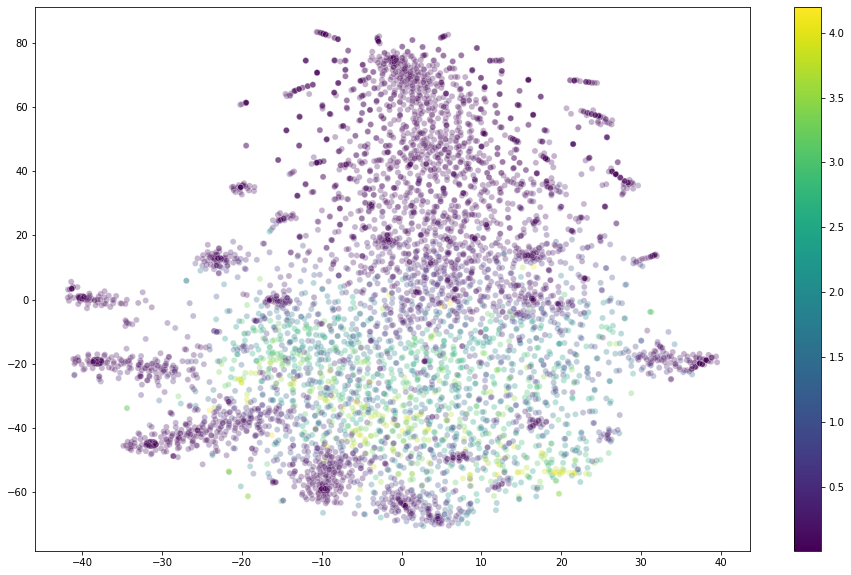

In [12]:
plt.figure(figsize=(16,10))
ax = sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=popularity_list,
    palette=sns.color_palette("viridis", as_cmap = True),
    alpha=0.3,
    legend=None
)
norm = plt.Normalize(min(popularity_list), max(popularity_list))
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
ax.figure.colorbar(sm)
plt.savefig('results/item_pop_tsne')
plt.show()

In [13]:
import pynndescent
pynndescent.rp_trees.FlatTree.__module__  = "pynndescent.rp_trees" #to fix weird error of umap

In [14]:
umap = UMAP.UMAP(n_neighbors=200,min_dist=1)
umap_results = umap.fit_transform(item_features_pca)

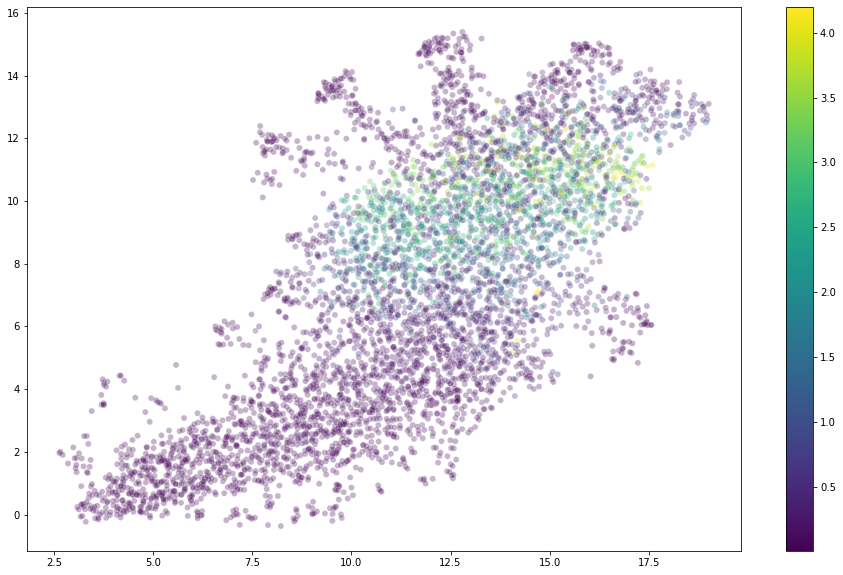

In [15]:
plt.figure(figsize=(16,10))
ax = sns.scatterplot(
    x=umap_results[:,0], y=umap_results[:,1],
    hue=popularity_list,
    palette=sns.color_palette("viridis", as_cmap = True),
    alpha=0.3,
    legend=None
)
norm = plt.Normalize(min(popularity_list), max(popularity_list))
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
ax.figure.colorbar(sm)
plt.savefig('results/item_pop_umap')
plt.show()

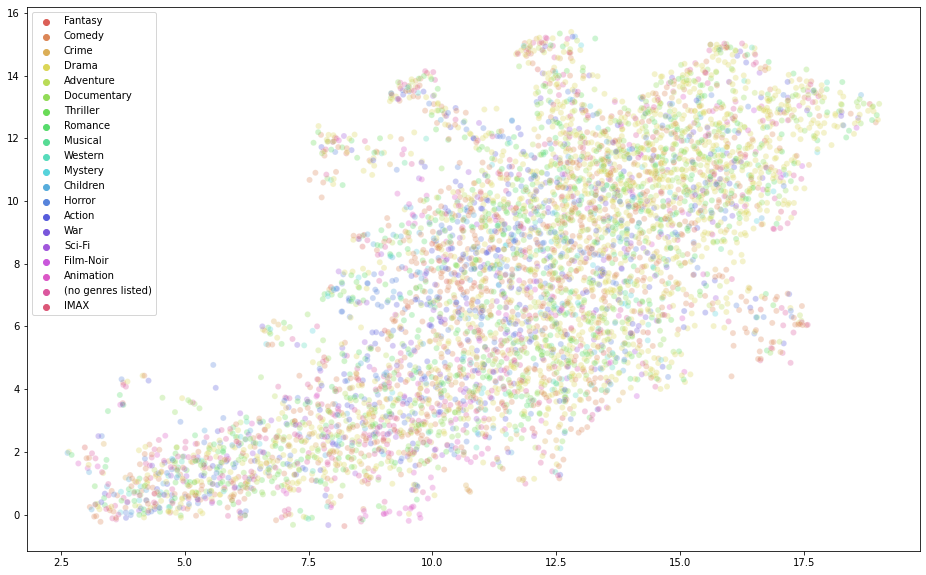

In [16]:
plt.figure(figsize=(16,10))
ax = sns.scatterplot(
    x=umap_results[:,0], y=umap_results[:,1],
    hue=genre_list,
    #hue_order=genre_hue_order,
    palette=sns.color_palette("hls", 20),
    alpha=0.3,
    legend="full"
)
plt.savefig('results/item_genre_umap')
plt.show()

## User

In [21]:
user_umap = UMAP.UMAP(n_neighbors=100, min_dist=0.1 )
user_umap_results = user_umap.fit_transform(user_features)

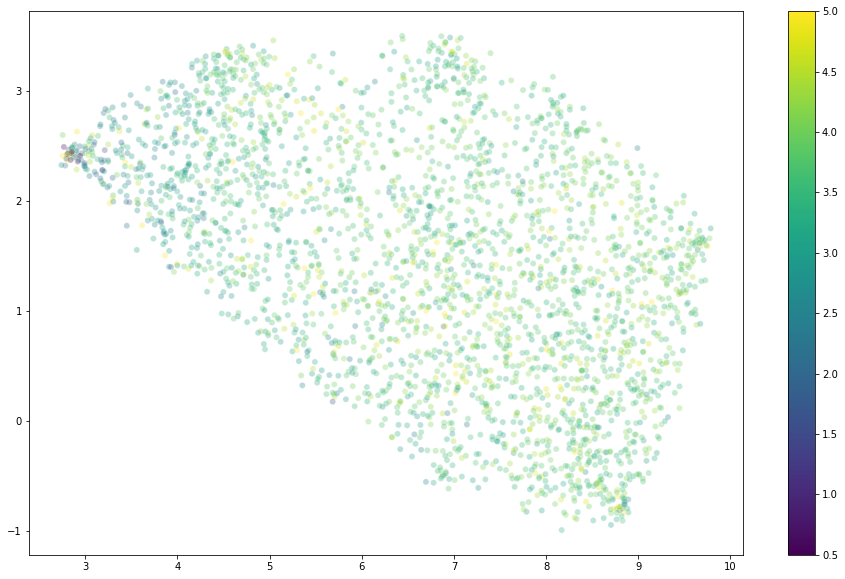

In [22]:
plt.figure(figsize=(16,10))
ax = sns.scatterplot(
    x=user_umap_results[:,0], y=user_umap_results[:,1],
    hue=rating_list,
    palette=sns.color_palette("viridis", as_cmap = True),
    alpha=0.3,
    legend=None
)
norm = plt.Normalize(min(rating_list), max(rating_list))
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
ax.figure.colorbar(sm)
plt.savefig('results/user_rating_umap')
plt.show()

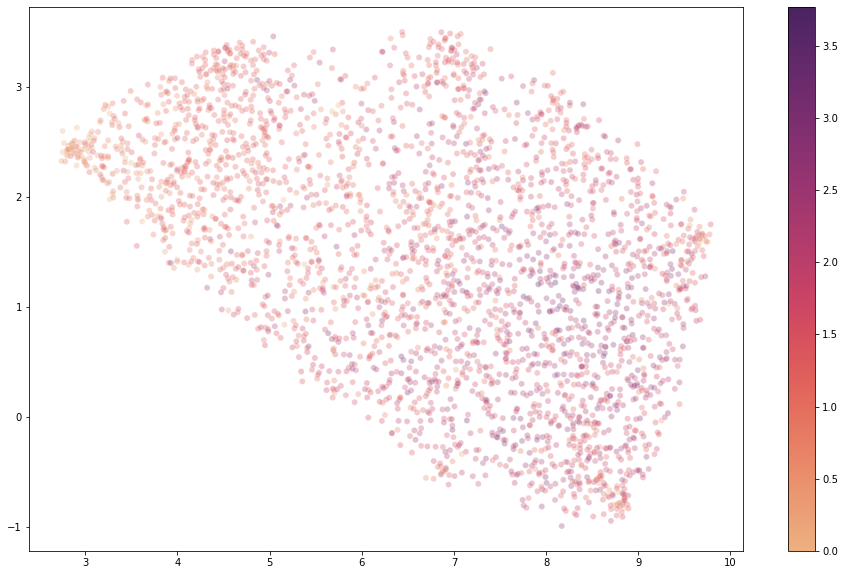

In [24]:
plt.figure(figsize=(16,10))
ax = sns.scatterplot(
    x=user_umap_results[:,0], y=user_umap_results[:,1],
    hue=np.log10(nmovie_list),
    palette=sns.color_palette("flare", as_cmap = True),
    alpha=0.3,
    legend=None
)
norm = plt.Normalize(min(np.log10(nmovie_list)), max(np.log10(nmovie_list)))
sm = plt.cm.ScalarMappable(cmap="flare", norm=norm)
sm.set_array([])
ax.figure.colorbar(sm)
plt.savefig('results/user_nmovie_umap')
plt.show()

## Predictions

In [ ]:
#!pip install wordcloud 

In [2]:
tag_df = pd.read_csv("results/tags.csv")

In [3]:
tag_df

,userId,movieId,tag,timestamp
0,14,110,epic,1443148538
1,14,110,Medieval,1443148532
2,14,260,sci-fi,1442169410
3,14,260,space action,1442169421
4,14,318,imdb top 250,1442615195
...,...,...,...,...
1108992,283206,73017,fun,1264379059
1108993,283206,73017,homoerotic subtext,1264379058
1108994,283206,73017,pacing,1264379058
1108995,283206,73017,plot,1264379058


In [4]:
def load_pred(filename="results/predictions_200"):
    pred_dict = {}
    with open(filename) as f:
        lines = f.readlines()
        for line in lines:
            line =  line[11:-3] # get rid of "Row(id=" in the beginning and "])\n" in the end
            line =  line.split(', movieId=[')
            idd = line[0] # first element is the id
            feat = [x for x in line[1].split(', ')] # second element are the features
            pred_dict[idd] = feat
    return pred_dict

pred_dict = load_pred()

In [5]:
true_df = pd.read_csv("results/test_df.csv")
true_dict = true_df.groupby('userId')['movieId'].apply(list).to_dict()
del true_dict['userId']

In [6]:
confident_movies = []
for k,v_list in true_dict.items():
    s = list(set(pred_dict[k][:50]).intersection(set(v_list)))
    if len(s) > 0 :
        for x in s:
            confident_movies.append(x)

In [7]:
movie_tag = tag_df.groupby('movieId')['tag'].apply(list).to_dict()
pop_words = []
for m in confident_movies:
    pop_words += movie_tag[int(m)]

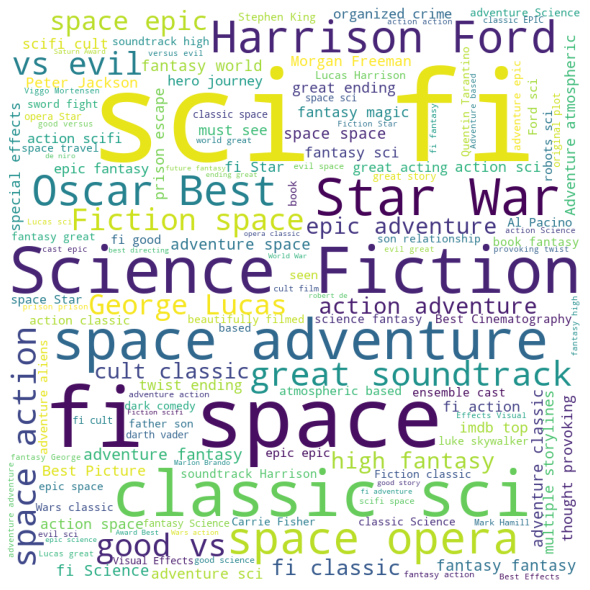

In [21]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd


comment_words = ''
stopwords = set(STOPWORDS)
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(' '.join(pop_words))
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.savefig('pop_words')
plt.show()

In [35]:
unconfident_movies = []
for k,v_list in true_dict.items():
    s = list(set(pred_dict[k]).intersection(set(v_list)))
    if len(s) == 0 :
        for x in v_list:
            unconfident_movies.append(x)

In [40]:
unpop_words = []
for m in unconfident_movies[:50]:
    if int(m) in movie_tag:
        for x in movie_tag[int(m)]:
            unpop_words.append(str(x))

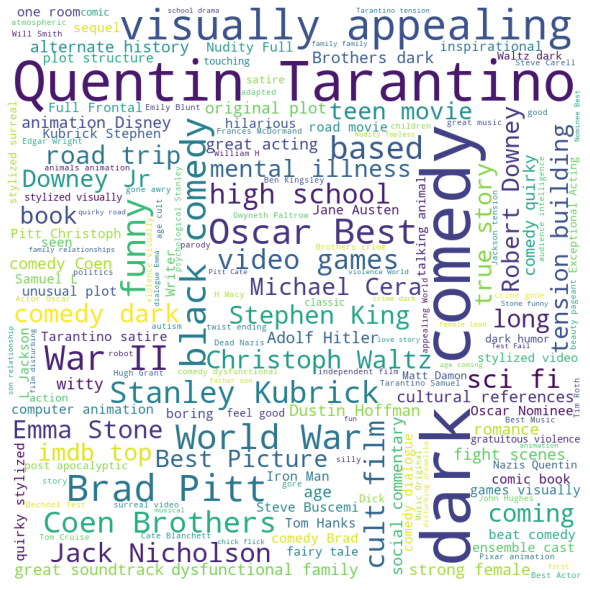

In [41]:
comment_words = ''
stopwords = set(STOPWORDS)
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(' '.join(unpop_words))
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.savefig('unpop_words')
plt.show()